# Map Zone Labelling

**ATTENTION**:
- mapping heppens for a single cell type: need to have all cells of a spefic cell type and get zone lebels for them (thus use a the corresponding cell type reference)
- Query must:
    - have same gene names --> "gene symbols" (not ensamble id)
    - be .h5ad
    - have raw counts in .X
- outputs
    - recomputed_stats.h5: Reference statistics per cell type
    - reference_markers.h5: Marker genes for reference cell types
q   - query_markers.json: Selected markers for query mapping ("markers useful for querying" not "based on a specific query dataset.")
    - **mapping_output.csv**: CSV table with:
        - Cell barcodes/IDs
        - Predicted cell type labels
        - Confidence/probability scores

Remember to download the mapping h5ad of referece datets:
```bash
    gsutil cp /broad/macosko/leematth/projects/zonation/akraft_new_objs/processed/STR_D1_Matrix_MSN.h5ad /broad/macosko/leematth/projects/zonation/akraft_new_objs/processed/STR_D2_Matrix_MSN.h5ad . 
```

The script works by:
- Computing statistics from a reference (annotated) dataset
- Finding marker genes
- Mapping query cells to reference cell types using those markers

In [ ]:
# MUST BE FIRST - before any imports from cell_type_mapper --> error if FromSpecifiedMarkersRunner run wiht GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

import pandas as pd
import scanpy as sc
import os
from dotenv import load_dotenv; load_dotenv()
import ipynbname
import shutil
import numpy as np
import matplotlib.pyplot as plt

# Hyperparamyters
BASE_PATH = os.getenv("BASE_PATH_FOR_SAVING")
DISEASE_TYPE = "diseased" # diseased / healthy
SAMPLE_ID = "sample_01"


ADATA_PATH = f'{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/adata/all_lib_adata.h5ad'
MAPPING_OUTPUT_FOLDER =  f'{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/zoning'

ZONE_LABELLING_SCRIPT = os.getenv("ZONE_LABELLING_SCRIPT")
ZONE_LABELLING_REFERENCES_FOLDER = os.getenv("ZONE_LABELLING_REFERENCES_FOLDER")
ZONE_LABELLING_STAT_FOLDER = f"{ZONE_LABELLING_REFERENCES_FOLDER}/stats"

ZONE_LABELS_COL_NAME_IN_REF = "D1_zones_6_assigned_v2" #ATTENTION: must be the same of the mapping scirpt
QUERY_CT_ANNOTATION = "zoning_msn_annotation"

# Check Query


In [2]:
query = sc.read_h5ad(ADATA_PATH)
print(query)

generic_ref = sc.read_h5ad("/home/gdallagl/myworkdir/XDP/data/STR_zonation_references_h5ad/STR_D1_Matrix_MSN.h5ad", backed="r")
print(generic_ref)

AnnData object with n_obs × n_vars = 85645 × 32780
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'my_hierarchy_all', 'library', 'library_name', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_scANVI'
    var: 'feature_types', 'genome', 'gene_symbol', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatche

In [3]:
# Has raw counts in .X?
    # will use raw counts duirn smaller adata creation

# Has same gene names? --> "gene symbol"
    # will set them duing the creatio of samller adata
query_gene_names = query.var_names
ref_gene_names = generic_ref.var_names
print(query_gene_names[:10])
print(ref_gene_names[:10])

query_gene_symbols = set(query.var["gene_symbol"])
print("\nPercenatge gene intersection:")
print(len(set(query_gene_symbols).intersection(ref_gene_names)) / len(ref_gene_names))

Index(['ENSG00000243485', 'ENSG00000290826', 'ENSG00000238009',
       'ENSG00000239945', 'ENSG00000239906', 'ENSG00000241860',
       'ENSG00000286448', 'ENSG00000290385', 'ENSG00000291215',
       'ENSG00000229905'],
      dtype='object', name='ensembl_id')
Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1', 'A2ML1-AS1',
       'A2ML1-AS2', 'A2MP1', 'A3GALT2'],
      dtype='object')

Percenatge gene intersection:
0.859701886294684


# Add ct annotation

Create  anew .obs col taht contains the cell type anntoation that we want to use

In [4]:
query_msn_mapping_dict = {
    
    # from Group Name mmc

    # ATTENTION
      # LOOSE DORSAL/VENTRAL
      # ASSUME ALL VENTRAL ARE MATRIX
    "STRd D1 Matrix MSN"          : "STR D1 Matrix MSN",
    "STRd D2 Matrix MSN"          : "STR D2 Matrix MSN",
    "STRv D1 MSN"                 : "STR D1 Matrix MSN",
    "STRv D2 MSN"                 : "STR D2 Matrix MSN",

    "STRd D1 Striosome MSN"       : "STRd D1 Striosome MSN",
    "STRd D2 Striosome MSN"       : "STRd D2 Striosome MSN",

    "STRd D2 StrioMat Hybrid MSN" : "STRd D2 StrioMat Hybrid MSN",
    "STRv D1 NUDAP MSN"           : "STRv D1 NUDAP MSN",
    "STR D1D2 Hybrid MSN"         : "STR D1D2 Hybrid MSN"
  }


query.obs[QUERY_CT_ANNOTATION] = query.obs.Group_name.map(query_msn_mapping_dict)

# Decide cell types

**ATTENTION**: multiple mapping not yet supported. I.e. do not create pairs where cell types are present also in other pairs.

Decide which pairs of: reference .h5ad --- cell type name

In [5]:
cell_type_mapping = {
    # reference name                : QUERY_CT_ANNOTATION

    "STR_D1_Matrix_MSN"             : "STR D1 Matrix MSN",
    "STR_D2_Matrix_MSN"             : "STR D2 Matrix MSN",

    # "STRd_D1_Striosome_MSN"         : "STRd D1 Striosome MSN",
    # "STRd_D2_Striosome_MSN"         : "STRd D2 Striosome MSN",

    # "STRd_D2_StrioMat_Hybrid_MSN"   : "STRd D2 StrioMat Hybrid MSN",
    # "STRv_D1_NUDAP_MSN"             : "STRv D1 NUDAP MSN",
    # "STR_D1D2_Hybrid_MSN"           : "STR D1D2 Hybrid MSN",
}

cell_type_to_map = pd.DataFrame(list(cell_type_mapping.items()), columns=["ct_zoning", "ct_mmc"])
cell_type_to_map

,ct_zoning,ct_mmc
0,STR_D1_Matrix_MSN,STR D1 Matrix MSN
1,STR_D2_Matrix_MSN,STR D2 Matrix MSN


# Create and save tmp query

<pre>
project/
│
├── ZONE_LABELLING_REFERENCES_FOLDER/
│   ├── ct_zoning_1.h5ad
│   ├── ct_zoning_2.h5ad
│   ├── ...
│   │
│   └── ZONE_LABELLING_STAT_FOLDER/
│       │
│       ├── ct_zoning_1/                      # Working directory per reference
│       │   ├── ct_mmc_*.h5ad                 # ⚠ Overwrites each run (Query h5ad)
│       │   ├── precomputed_stats.h5          # ✓ Reusable across queries (independent of query)
│       │   ├── reference_markers.h5          # ✓ Reusable across queries (independent of query)
│       │   ├── query_markers.json            # ✓ Reusable across queries (independent of query)
│       │   ├── mapping_output.csv            # ⚠ Overwrites each run (ie, the query is different but for this ct_zoning cell type)
│       │   └── mapping_output.json           # ⚠ Overwrites each run (ie, the query is different but for this ct_zoning cell type)
│       │
│       ├── ct_zoning_2/
│       │   └── ...
│       └── ...
│
└── MAPPING_OUTPUT_FOLDER/
    │
    ├── ct_mmc_1/                             # Final results per query cell type
    │   ├── mapping_output.csv                # ✓ Preserved copy
    │   └── mapping_output.json               # ✓ Preserved copy
    │
    ├── ct_mmc_2/
    │   ├── mapping_output.csv
    │   └── mapping_output.json
    └── ...

</pre>


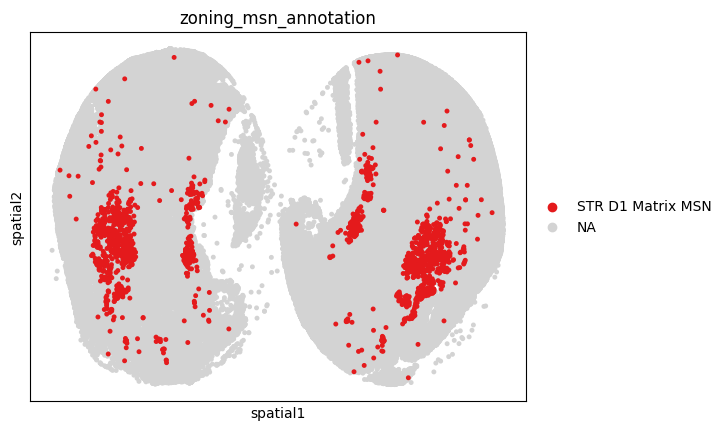

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D1_Matrix_MSN/STR_D1_Matrix_MSN.h5ad
AnnData object with n_obs × n_vars = 1653 × 32780


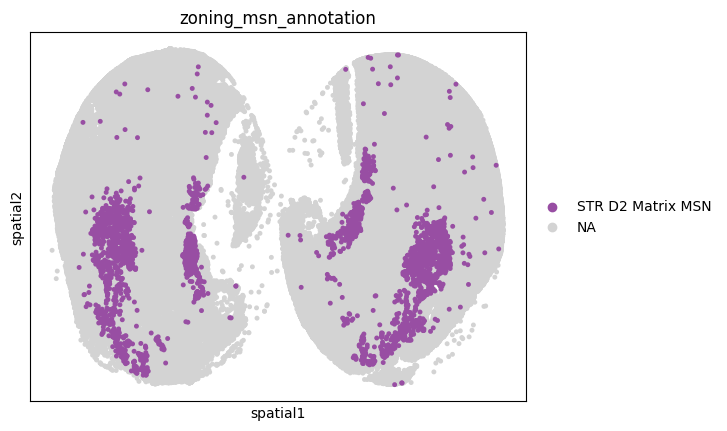

/home/gdallagl/myworkdir/XDP/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1798: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


/home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D2_Matrix_MSN/STR_D2_Matrix_MSN.h5ad
AnnData object with n_obs × n_vars = 2975 × 32780


In [ ]:
# Initialize DataFrame columns
cell_type_to_map["ref_path"] = ""
cell_type_to_map["query_path"] = ""
cell_type_to_map["working_folder_for_this_ct_zoning"] = "" #(passed as -o to shell)
cell_type_to_map["final_output_folder"] = ""


for i, row in cell_type_to_map.iterrows():

    ct_mmc_formatted = row["ct_mmc"].replace(" ", "_")
    
    # Set paths
    working_folder_for_this_ct_zoning = os.path.join(ZONE_LABELLING_STAT_FOLDER, row["ct_zoning"])
    final_output_folder = os.path.join(MAPPING_OUTPUT_FOLDER, ct_mmc_formatted)
    os.makedirs(working_folder_for_this_ct_zoning, exist_ok=True)
    os.makedirs(final_output_folder, exist_ok=True)

    ref_path = os.path.join(ZONE_LABELLING_REFERENCES_FOLDER, f"{row['ct_zoning']}.h5ad") # reference h5ad
    query_path = os.path.join(working_folder_for_this_ct_zoning, f"{ct_mmc_formatted}.h5ad") # where subsample query will be saved
    
    # Store in DataFrame
    cell_type_to_map.loc[i, "working_folder_for_this_ct_zoning"] = working_folder_for_this_ct_zoning
    cell_type_to_map.loc[i, "final_output_folder"] = final_output_folder
    cell_type_to_map.loc[i, "ref_path"] = ref_path
    cell_type_to_map.loc[i, "query_path"] = query_path

    # spatial
    sc.pl.embedding(query, basis="spatial", color=QUERY_CT_ANNOTATION, groups=row["ct_mmc"], size=30, palette=["red"])
    
    # Create query subset
    adata_ct = query[query.obs[QUERY_CT_ANNOTATION] == row["ct_mmc"]].copy() # not formaltted name

    adata_ct_minimal = sc.AnnData(
        X=adata_ct.layers["counts"],                     # ATTENTION: .X must be raw counts
        obs=pd.DataFrame(index=adata_ct.obs_names),
        var=pd.DataFrame(index=adata_ct.var["gene_symbol"]) # ATTENTION: gene names must be gene symbol (same of ref)
    )

    print(query_path)
    print(adata_ct_minimal)
    adata_ct_minimal.write(query_path)

    

## Check that all references have Cell type col for mapping

In [7]:
for i, row in cell_type_to_map.iterrows():

    print(row["ct_zoning"], row["ref_path"])
    
    adata = sc.read_h5ad(row["ref_path"], backed="r")

    print(f"\t{ZONE_LABELS_COL_NAME_IN_REF}", ZONE_LABELS_COL_NAME_IN_REF in adata.obs.columns)



STR_D1_Matrix_MSN /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/STR_D1_Matrix_MSN.h5ad
	D1_zones_6_assigned_v2 True
STR_D2_Matrix_MSN /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/STR_D2_Matrix_MSN.h5ad
	D1_zones_6_assigned_v2 True


# Run bash command for mapping

In [8]:
!chmod +x {ZONE_LABELLING_SCRIPT}

In [9]:
import subprocess

for i, row in cell_type_to_map.iterrows():
    
    # Create command
    cmd = [
        ZONE_LABELLING_SCRIPT,
        "-r", row["ref_path"],
        "-q", row["query_path"],
        "-o", row["working_folder_for_this_ct_zoning"]
        # "-c" # Without -c: Do not recalculate the existing files, but the final mapping csv is recalucted 
    ]
    
    print(f"Processing dataset {row['ct_zoning']}...")
    result = subprocess.run(cmd, capture_output=True, text=True) # Waits for script to complete (blocks until done)
    
    # Print output
    print(result.stdout)
    if result.returncode != 0: # 0 id siccessful
        print(f"Error: {result.stderr}")
    
    # Copy results to final folder
    print("Copying results...")
    shutil.copy2(
        os.path.join(row["working_folder_for_this_ct_zoning"], "mapping_output.csv"),
        os.path.join(row["final_output_folder"], "mapping_output.csv")
    )
    shutil.copy2(
        os.path.join(row["working_folder_for_this_ct_zoning"], "mapping_output.json"),
        os.path.join(row["final_output_folder"], "mapping_output.json")
    )



Processing dataset STR_D1_Matrix_MSN...
/home/gdallagl/myworkdir/data/STR_zonation_references_h5ad
make output directory
Reference Directory: /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad
Query Directory: /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D1_Matrix_MSN/STR_D1_Matrix_MSN.h5ad
Output Directory: /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D1_Matrix_MSN
get precomputed stats
finally process 34170 tot 1.19e+01 reading 1.26e+00 writing 2.68e-02
finally process 34169 tot 2.99e+01 reading 3.22e+00 writing 2.64e-02
finally process 34168 tot 2.99e+01 reading 3.24e+00 writing 2.51e-02
get reference markers
writing /home/gdallagl/myworkdir/data/STR_zonation_references_h5ad/stats/STR_D1_Matrix_MSN/reference_markers.h5
Starting precomputed_stats.h5
8 of 15 taxon pairs in 1.15e-01 sec; predict 1.00e-01 sec of 2.15e-01 sec left
16 of 15 taxon pairs in 1.19e-01 sec; predict -7.43e-03 sec of 1.11e-01 sec left
Initial marker discove

# Add labels to adata

In [10]:
# Intiialse
query.obs[f"{ZONE_LABELS_COL_NAME_IN_REF}_name"] = np.nan
query.obs[f"{ZONE_LABELS_COL_NAME_IN_REF}_bootstrapping_probability"] = np.nan

# Loop through each cell type
for i, row in cell_type_to_map.iterrows():
    
    # Read the mapping results
    df = pd.read_csv(os.path.join(row["final_output_folder"], "mapping_output.csv"), comment="#")
    df.set_index("cell_id", inplace=True)
    df = df[[f"{ZONE_LABELS_COL_NAME_IN_REF}_name", 
             f"{ZONE_LABELS_COL_NAME_IN_REF}_bootstrapping_probability"]]
    
    # Match cell IDs between df and adata
    common_cells = query.obs_names.intersection(df.index)
    query.obs.loc[common_cells, f"{ZONE_LABELS_COL_NAME_IN_REF}_name"] = df.loc[common_cells, f"{ZONE_LABELS_COL_NAME_IN_REF}_name"]
    query.obs.loc[common_cells, f"{ZONE_LABELS_COL_NAME_IN_REF}_bootstrapping_probability"] = df.loc[common_cells, f"{ZONE_LABELS_COL_NAME_IN_REF}_bootstrapping_probability"]
    
    print(f"Processed {row['ct_mmc']}: matched {len(common_cells)} cells")

# Convert to categorical after all data is added
col_name = f"{ZONE_LABELS_COL_NAME_IN_REF}_name"
query.obs[col_name] = pd.Categorical(query.obs[col_name].astype("Int64")) #Preserve NaN as NaN (not convert to string "nan")

query

Processed STR D1 Matrix MSN: matched 1653 cells
Processed STR D2 Matrix MSN: matched 2975 cells


AnnData object with n_obs × n_vars = 85645 × 32780
    obs: 'x', 'y', 'pct_intronic', 'is_cell', 'dbscan_clusters', 'dbscan_score', 'has_spatial', 'Neighborhood_name', 'Neighborhood_bootstrapping_probability', 'Neighborhood_aggregate_probability', 'Class_name', 'Class_bootstrapping_probability', 'Class_aggregate_probability', 'Subclass_name', 'Subclass_bootstrapping_probability', 'Subclass_aggregate_probability', 'Group_name', 'Group_bootstrapping_probability', 'Group_aggregate_probability', 'Cluster_label', 'Cluster_name', 'Cluster_alias', 'Cluster_bootstrapping_probability', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'my_hierarchy_all', 'library', 'library_name', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'leiden_scANVI', 'zoning_msn_annotation', 'D1_zones_6_assigned_v2_name', 'D1_zones_6_assigned_v2_bootstrapping_probability'
    var: 'feature_types', 'genome', 'gene_symbol',

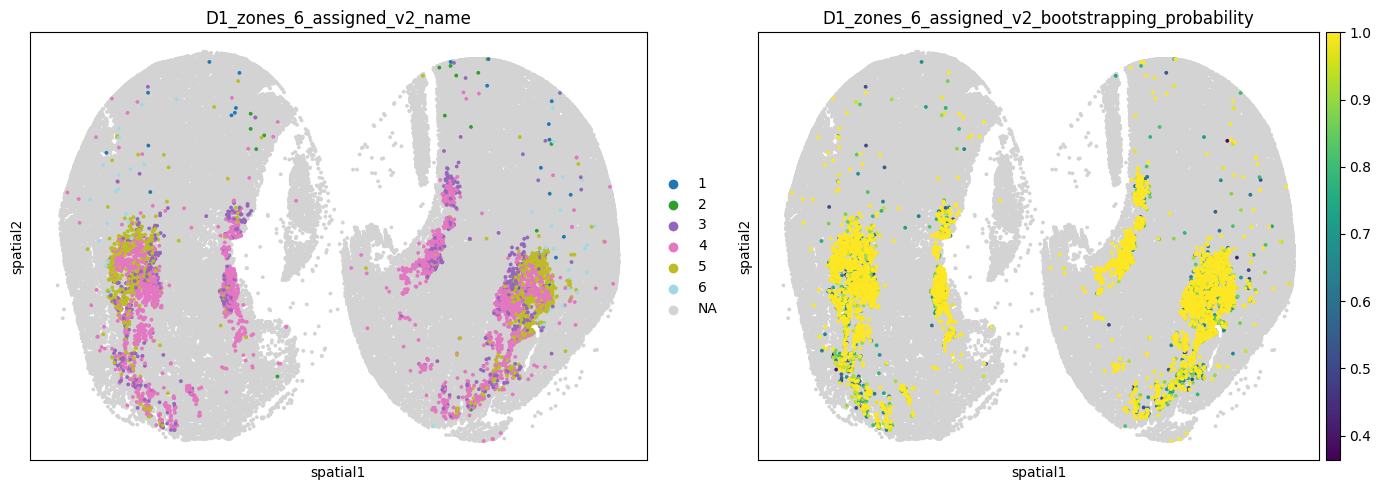

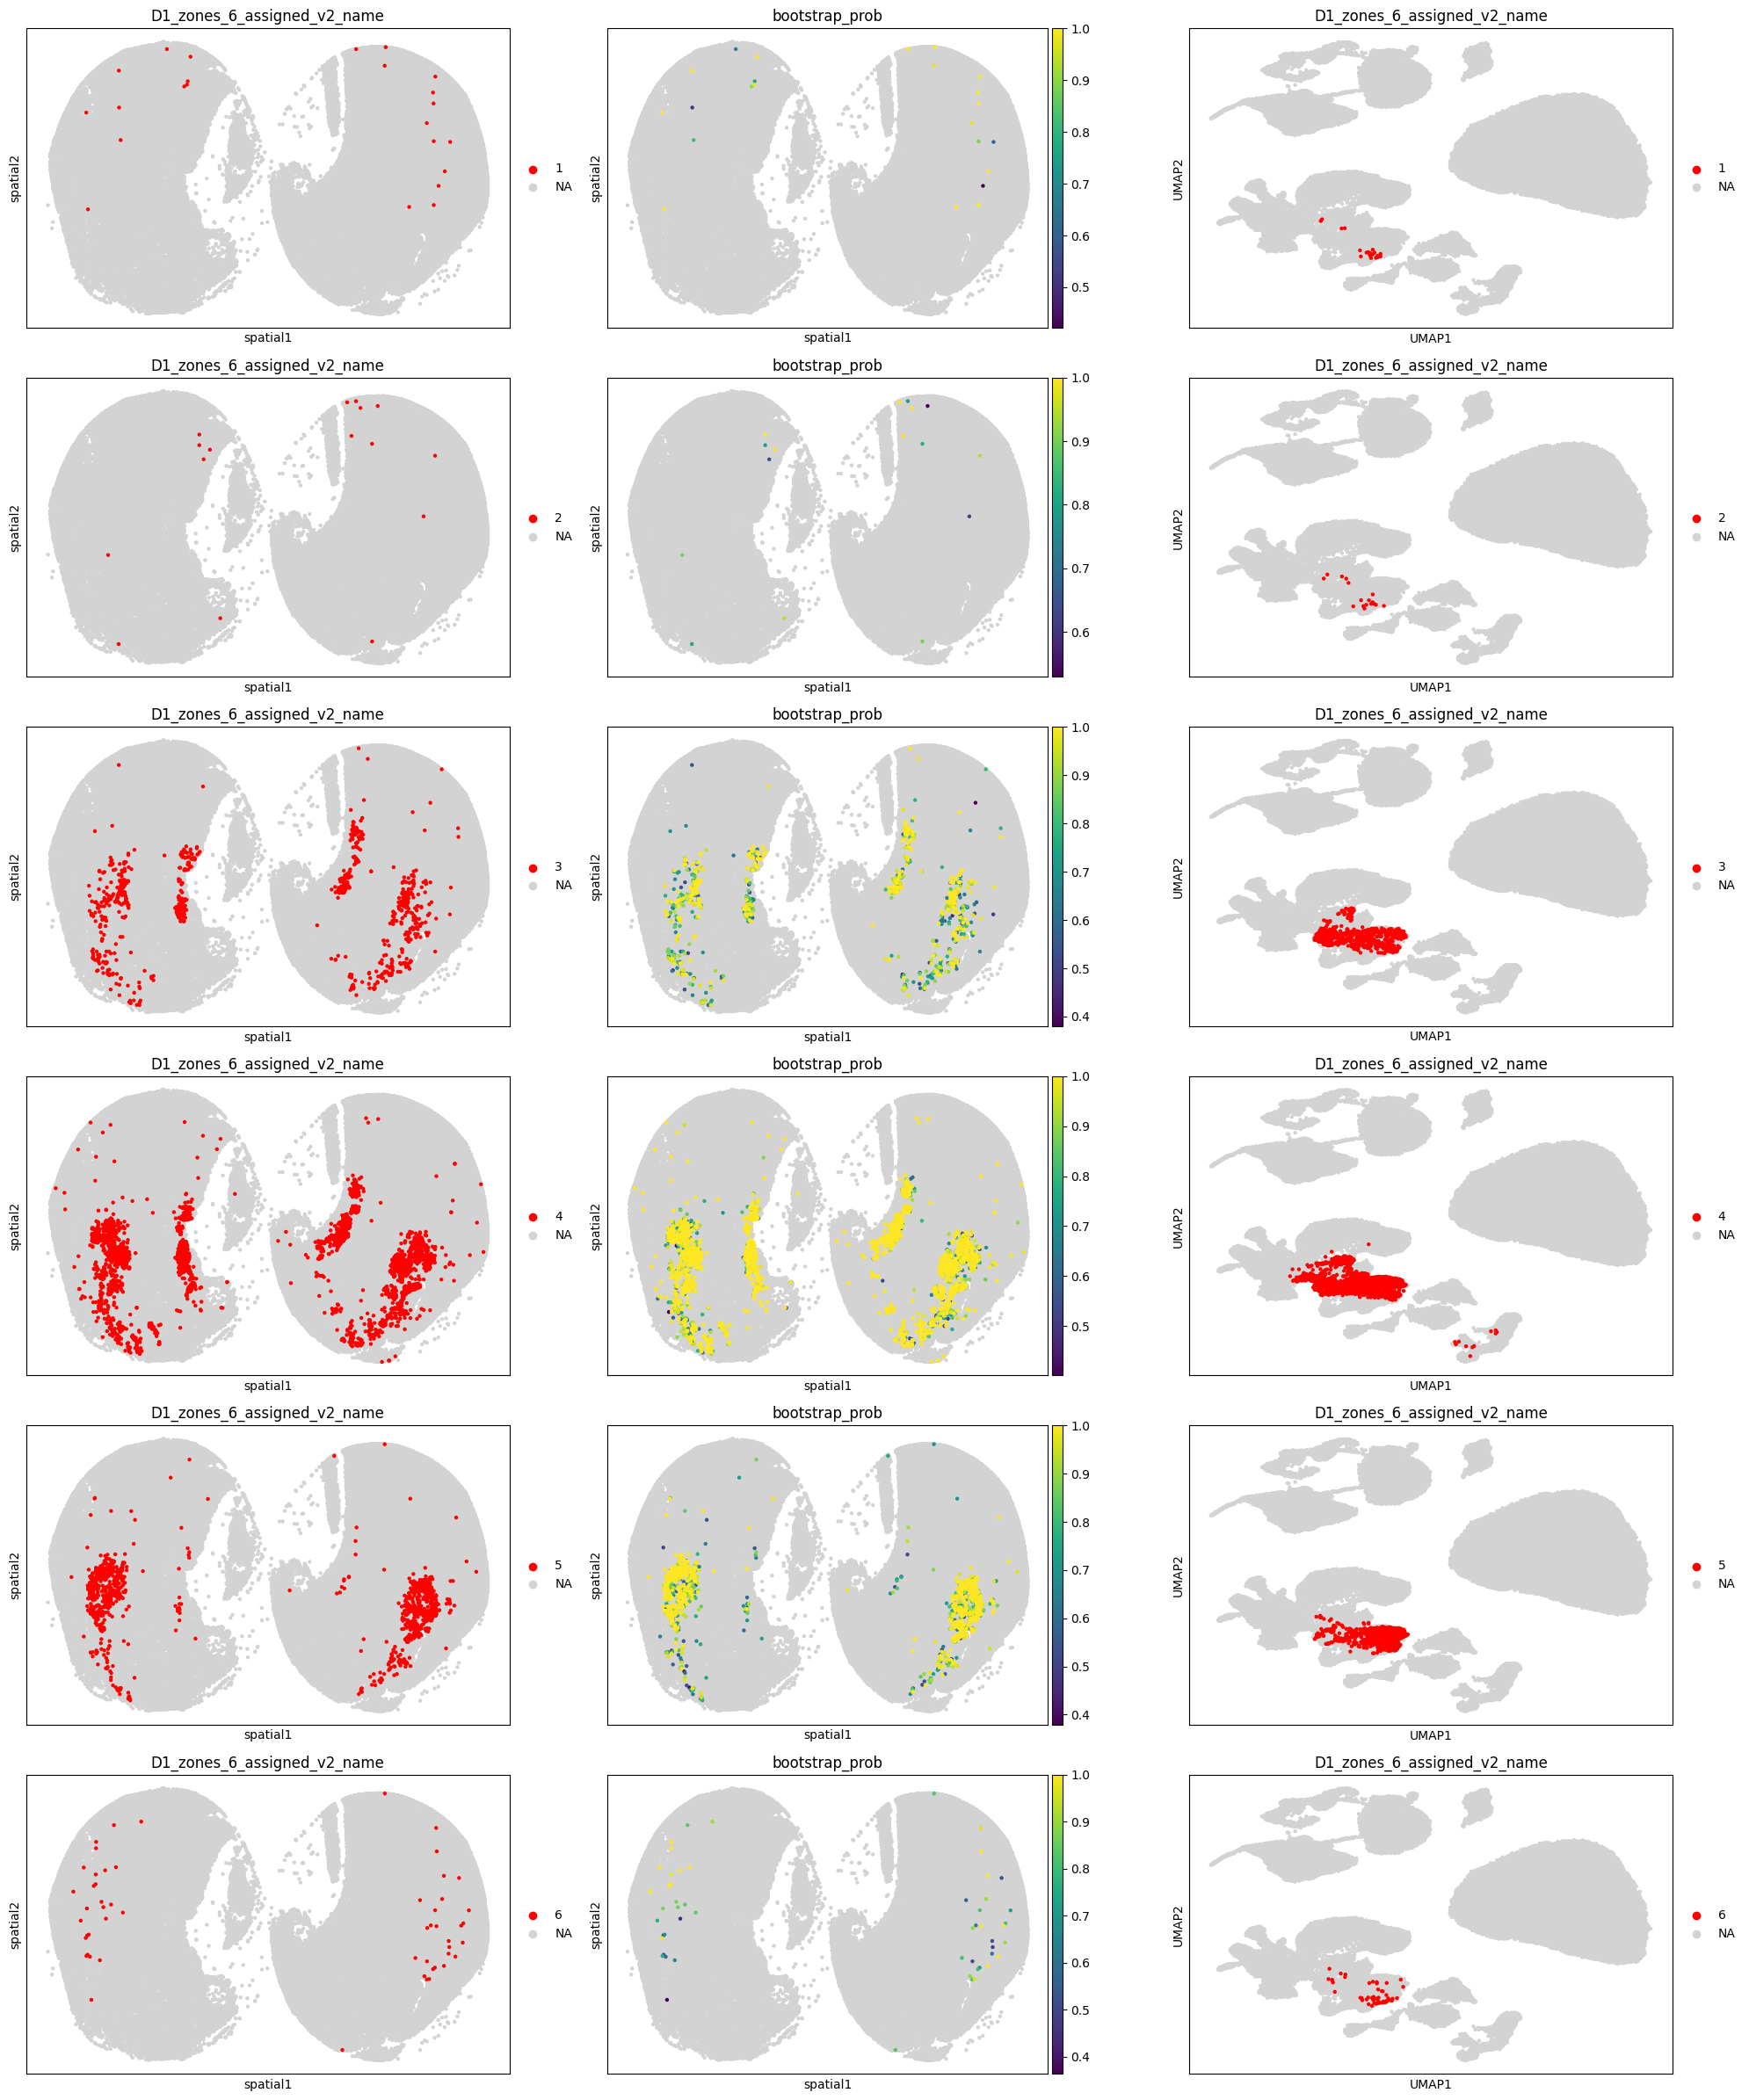

In [11]:
ct_col = f"{ZONE_LABELS_COL_NAME_IN_REF}_name"
prob_col = f"{ZONE_LABELS_COL_NAME_IN_REF}_bootstrapping_probability"


fig,axs=plt.subplots(1,2,figsize=(14,5))
sc.pl.embedding(query,basis="spatial",color=ct_col,size=30,palette="tab20",ax=axs[0],show=False)
sc.pl.embedding(query,basis="spatial",color=prob_col,size=30,ax=axs[1],show=False)
plt.tight_layout(); plt.show()



zones = sorted(query.obs[ct_col].unique().tolist())[1:]

fig, axes = plt.subplots(len(zones), 3, figsize=(20, 4 * len(zones)))

for i, zone in enumerate(zones):

    query.obs['bootstrap_prob'] = np.nan
    mask = query.obs[ct_col] == zone
    query.obs.loc[mask, 'bootstrap_prob'] = query.obs.loc[mask, prob_col]

    size=40
    sc.pl.embedding(query, basis="spatial", color=ct_col, size=size, palette=["red"], groups=[zone], ax=axes[i,0], show=False)
    sc.pl.embedding(query, basis="spatial", color="bootstrap_prob", size=size, ax=axes[i,1], show=False)
    sc.pl.umap(query, color=ct_col, size=size, palette=["red"], groups=[zone], ax=axes[i,2], show=False)

query.obs.drop(columns=['bootstrap_prob'], inplace=True)

plt.tight_layout()
plt.show()

# Save Notebook

In [12]:
# Get the notebook path
notebook_path = str(ipynbname.path())
print(f"Current notebook: {notebook_path}")

# Save it
base_name = os.path.basename(notebook_path).replace('.ipynb', '')  # Remove .ipynb
saving_path = f"{BASE_PATH}/{DISEASE_TYPE}/{SAMPLE_ID}/notebooks/{base_name}.ipynb"
print(f"Saved to {saving_path}")

print("\n   Press Ctrl+S")

Current notebook: /home/gdallagl/myworkdir/XDP/script/single_sample_analysis/05_zone_labelling.ipynb
Saved to /home/gdallagl/myworkdir/data/XDP/diseased/sample_01/notebooks/05_zone_labelling.ipynb

   Press Ctrl+S


In [14]:
shutil.copy(notebook_path, saving_path)

'/home/gdallagl/myworkdir/data/XDP/diseased/sample_01/notebooks/05_zone_labelling.ipynb'